In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from collections import Counter
from collections import defaultdict

#!pip install scikit-plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

In [3]:
df_test = pd.read_csv("/content/Test_ripulito")
df_train = pd.read_csv("/content/Train_ripulito")

In [4]:
df_test = df_test.drop(columns=['Unnamed: 0'],axis=1)
df_train = df_train.drop(columns=['Unnamed: 0'],axis=1)

In [5]:
df_train_copy = df_train
df_test_copy = df_test

In [6]:
t_train = df_train.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename'])
t_test = df_test.drop(columns=['vocal_channel', 'emotion', 'emotional_intensity', 'statement', 'repetition', 'sex', 'filename'])

In [7]:
columns_train = []
columns_train = t_train.columns
columns_test = []
columns_test = t_test.columns

In [8]:
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(t_train)
#print(x_train_norm)
x_test_norm = scaler.transform(t_test)
#print(x_test_norm)

In [9]:
df_trainNORM = pd.DataFrame(x_train_norm, columns = columns_train)
df_testNORM = pd.DataFrame(x_test_norm, columns = columns_test)

In [10]:
"""df_trainNORM = df_trainNORM.assign(vocal_channel = df_train_copy['vocal_channel'].values)
df_trainNORM = df_trainNORM.assign(emotional_intensity = df_train_copy['emotional_intensity'].values)
df_trainNORM = df_trainNORM.assign(statement = df_train_copy['statement'].values)
df_trainNORM = df_trainNORM.assign(repetition = df_train_copy['repetition'].values)
df_trainNORM = df_trainNORM.assign(sex = df_train_copy['sex'].values)
df_trainNORM = df_trainNORM.assign(filename = df_train_copy['filename'].values)"""
df_trainNORM = df_trainNORM.assign(emotion = df_train_copy['emotion'].values)

In [11]:
"""df_testNORM = df_testNORM.assign(vocal_channel = df_test_copy['vocal_channel'].values)
df_testNORM = df_testNORM.assign(emotional_intensity = df_test_copy['emotional_intensity'].values)
df_testNORM = df_testNORM.assign(statement = df_test_copy['statement'].values)
df_testNORM = df_testNORM.assign(repetition = df_test_copy['repetition'].values)
df_testNORM = df_testNORM.assign(sex = df_test_copy['sex'].values)
df_testNORM = df_testNORM.assign(filename = df_test_copy['filename'].values)"""
df_testNORM = df_testNORM.assign(emotion = df_test_copy['emotion'].values)

aggiungo colonna happy al dataset di test e train dopo averli normalizzati 

In [12]:
train_happy = []
for value in df_trainNORM['emotion']:
  if(value == 'happy'):
    train_happy.append(1)
  else:
    train_happy.append(0)

In [13]:
df_trainNORM = df_trainNORM.assign(happy = train_happy)

In [14]:
test_happy = []
for value in df_testNORM['emotion']:
  if(value == 'happy'):
    test_happy.append(1)
  else:
    test_happy.append(0)

In [15]:
df_testNORM = df_testNORM.assign(happy = test_happy)

Uso dataset originale ripulito e basta.

In [20]:
X_train = df_trainNORM.drop(columns = ['happy', 'emotion'])
y_train = df_trainNORM[['happy']]
X_test = df_testNORM.drop(columns = ['happy', 'emotion'])
y_test = df_testNORM[['happy']]
#0 not happy, 1 happy

In [17]:
#!pip install scikit-plot
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from scikitplot.metrics import plot_precision_recall, plot_roc, plot_cumulative_gain, plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_roc_curve
from sklearn.model_selection import KFold, StratifiedKFold,RepeatedStratifiedKFold, cross_val_score, KFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, classification_report

Definizione funzione Grid Search

In [18]:
# Funzione per fare la GridSearch()
def customGridSearch(X_train, y_train, model, tuned_parameters,score):

    print("____________________________________________ START GRID SEARCH ____________________________________________")

    results = {}
    
    print("------- Score = " + score +  "------- \n")
        
    k_fold = RepeatedStratifiedKFold() # 5 split default, 10 repetitions default
    print("> Fold = " + str(k_fold) + "\n")
        
    clf = GridSearchCV(model, tuned_parameters, error_score='raise', cv=k_fold, scoring = score, return_train_score=True)
    clf.fit(X_train, y_train)

    print("> Best Parameter set: \n")
    best = clf.best_params_
    print(best)
        
    print("\n> Grid scores:\n")

    means = clf.cv_results_['mean_train_score']
    stds = clf.cv_results_['std_train_score']

    print("...........RESULTS FOR TRAINING.........")
    print("........................................")

   
    
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                          
    print("____________________________________________ END GRID SEARCH ____________________________________________")
        
    results[score] = best
    
    return results

Iniziamo con le tecniche di dimensionality reduction

Variance Threshold

In [23]:
from sklearn.decomposition import PCA
from itertools import product
from yellowbrick.datasets import load_credit
from yellowbrick.features import PCA as yPCA

from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.contrib.classifier import DecisionViz

from sklearn.feature_selection import VarianceThreshold

In [27]:
def test_threshold(classifier):
    ran = [0.03, 0.04, 0.05, 0.10, 0.15, 0.18, 0.19, 0.2]
    print(classifier)
    for i in ran:
        print(i)
        sel = VarianceThreshold(i)
        X_train_sel = sel.fit_transform(X_train)

        print(X_train_sel.shape)
        X_test_sel = sel.transform(X_test)

        clf = classifier
        clf.fit(X_train_sel, y_train['happy'])

        y_pred = clf.predict(X_test_sel)

        print('Accuracy %s' % accuracy_score(y_test, y_pred))
        print('F1-score %s' % f1_score(y_test, y_pred, average=None))
        print(classification_report(y_test, y_pred))

In [28]:
test_threshold(DecisionTreeClassifier(min_samples_leaf=3, random_state=1000))
test_threshold(KNeighborsClassifier(n_neighbors=5))

DecisionTreeClassifier(min_samples_leaf=3, random_state=1000)
0.03
(1828, 197)
Accuracy 0.7756410256410257
F1-score [0.86538462 0.32692308]
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       528
           1       0.30      0.35      0.33        96

    accuracy                           0.78       624
   macro avg       0.59      0.60      0.60       624
weighted avg       0.79      0.78      0.78       624

0.04
(1828, 197)
Accuracy 0.7756410256410257
F1-score [0.86538462 0.32692308]
              precision    recall  f1-score   support

           0       0.88      0.85      0.87       528
           1       0.30      0.35      0.33        96

    accuracy                           0.78       624
   macro avg       0.59      0.60      0.60       624
weighted avg       0.79      0.78      0.78       624

0.05
(1828, 197)
Accuracy 0.7756410256410257
F1-score [0.86538462 0.32692308]
              precision    recall  f1-score   supp

In [29]:
thresholds = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.15, 0.16, 0.19]
for i in thresholds:
    sel = VarianceThreshold(i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train, y_train['happy'])
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train_sel, y_train['happy'])
    y_pred = clf.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=1000)
    clf.fit(X_train_sel, y_train['happy'])
    y_pred = clf.predict(X_test_sel)
    print('DecisionTree - Accuracy %s' % accuracy_score(y_test, y_pred))
  

0.02
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.04
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.06
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.08
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.1
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.12
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.15
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.16
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257
0.19
(1828, 197)
KNN - Accuracy 0.8108974358974359
DecisionTree - Accuracy 0.7756410256410257


stesso metodo ma applicando la grid search

In [31]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_train_sel = sel.fit_transform(X_train)
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(1828, 197)

In [33]:
check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}

dt=DecisionTreeClassifier()
          
results = customGridSearch(X_train_sel, y_train['happy'], dt, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 9, 'min_samples_split': 5}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
0.676 (+/-0.042) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.673 (+/-0.043) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.671 (+/-0.044) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}
0.666 (+/-0.048) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 20}
0.666 (+/-0.047) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.666 (+/-0.047) for {'criterion': 'g

In [34]:
results

{'f1_macro': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 9,
  'min_samples_split': 5}}

In [35]:
#decision tree
clf = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, min_samples_leaf = 9, min_samples_split = 5, random_state=42)
clf.fit(X_train_sel, y_train['happy'])

y_pred = clf.predict(X_test_sel)
print('Decision Tree')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Decision Tree
Accuracy 0.7692307692307693
F1-score [0.86691312 0.13253012]
              precision    recall  f1-score   support

           0      0.847     0.888     0.867       528
           1      0.157     0.115     0.133        96

    accuracy                          0.769       624
   macro avg      0.502     0.501     0.500       624
weighted avg      0.741     0.769     0.754       624



In [36]:
check_params = {'n_neighbors': [1, 5, 10, 15, 20], "weights":["distance", "uniform"], 'metric' :['minkowski', 'manhattan', 'euclidean']}

clf=KNeighborsClassifier()
          
results = customGridSearch(X_train_sel, y_train['happy'], clf, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'distance'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.760 (+/-0.027) for {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
0.545 (+/-0.028) for {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 15, 'weights': '

In [37]:
results

{'f1_macro': {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}}

In [40]:
#knn
clf = KNeighborsClassifier(metric ='manhattan', n_neighbors=1, weights ='distance')
clf.fit(X_train_sel, y_train['happy'])

y_pred = clf.predict(X_test_sel)
print('KNN')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

KNN
Accuracy 0.7708333333333334
F1-score [0.86419753 0.26666667]
              precision    recall  f1-score   support

           0      0.867     0.862     0.864       528
           1      0.263     0.271     0.267        96

    accuracy                          0.771       624
   macro avg      0.565     0.566     0.565       624
weighted avg      0.774     0.771     0.772       624



Univariate Feature Selection
1.   It selects the best features based on univariate statistical tests.


In [42]:
#scelta del k
from sklearn.feature_selection import SelectKBest
for i in range(1, 197):
    sel = SelectKBest(k=i)
    print(str(i))
    X_train_sel = sel.fit_transform(X_train, y_train['happy'])
    print(X_train_sel.shape)
    X_test_sel = sel.transform(X_test)

    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(X_train_sel, y_train['happy'])
    y_pred = clf.predict(X_test_sel)
    print('KNN - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('kNN - F1-score %s' % f1_score(y_test, y_pred, average=None))
    #print(classification_report(y_test, y_pred, digits=3))
    
    clf = DecisionTreeClassifier(min_samples_leaf=3, random_state=1000)
    clf.fit(X_train_sel, y_train['happy'])
    y_pred = clf.predict(X_test_sel)
    print('DecisionTree - Accuracy %s' % accuracy_score(y_test, y_pred))
    print('DecisionTree - F1-score %s' % f1_score(y_test, y_pred, average=None))
    #print(classification_report(y_test, y_pred, digits=3))

    #migliori risultati con k=83 per decision tree e k=137 per il KNN



1
(1828, 1)
KNN - Accuracy 0.8157051282051282
kNN - F1-score [0.89686099 0.13533835]
DecisionTree - Accuracy 0.7772435897435898
DecisionTree - F1-score [0.87069767 0.19653179]
2
(1828, 2)
KNN - Accuracy 0.8189102564102564
kNN - F1-score [0.90008842 0.03418803]
DecisionTree - Accuracy 0.7932692307692307
DecisionTree - F1-score [0.88066605 0.22754491]
3
(1828, 3)
KNN - Accuracy 0.8221153846153846
kNN - F1-score [0.90009001 0.18978102]
DecisionTree - Accuracy 0.7964743589743589
DecisionTree - F1-score [0.88506787 0.11188811]
4
(1828, 4)
KNN - Accuracy 0.8285256410256411
kNN - F1-score [0.90351668 0.23021583]
DecisionTree - Accuracy 0.7724358974358975
DecisionTree - F1-score [0.86924494 0.12345679]
5
(1828, 5)
KNN - Accuracy 0.8269230769230769
kNN - F1-score [0.90339893 0.16923077]
DecisionTree - Accuracy 0.7580128205128205
DecisionTree - F1-score [0.85901027 0.14689266]
6
(1828, 6)
KNN - Accuracy 0.8108974358974359
kNN - F1-score [0.89154412 0.2625    ]
DecisionTree - Accuracy 0.772435897

Al migliore risultato, applicato la grid search: 
    #migliori risultati con k=83 per decision tree e k=137 per il KNN

In [43]:
sel = SelectKBest(k=83)
X_train_sel = sel.fit_transform(X_train, y_train)
print(X_train_sel.shape)
X_test_sel = sel.transform(X_test)

(1828, 83)


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [44]:
check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_sel, y_train['happy'], dt, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
0.670 (+/-0.047) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.668 (+/-0.048) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.664 (+/-0.051) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}
0.661 (+/-0.054) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 20}
0.663 (+/-0.052) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.663 (+/-0.052) for {'criterion':

In [45]:
results

{'f1_macro': {'criterion': 'entropy',
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 5}}

In [46]:
#decision tree
clf = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, min_samples_leaf=5, min_samples_split=5, random_state=42)
clf.fit(X_train_sel, y_train['happy'])

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.7788461538461539
F1-score [0.87316176 0.1375    ]
              precision    recall  f1-score   support

           0      0.848     0.900     0.873       528
           1      0.172     0.115     0.137        96

    accuracy                          0.779       624
   macro avg      0.510     0.507     0.505       624
weighted avg      0.744     0.779     0.760       624



In [47]:
sel = SelectKBest(k=137)
X_train_sel = sel.fit_transform(X_train, y_train)
print(X_train_sel.shape)
X_test_sel = sel.transform(X_test)

(1828, 137)


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [48]:
check_params = {'n_neighbors': [1, 5, 10, 15, 20], "weights":["distance", "uniform"], 'metric' :['minkowski', 'manhattan', 'euclidean']}
clf=KNeighborsClassifier()
results = customGridSearch(X_train_sel, y_train['happy'], clf, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'distance'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.775 (+/-0.026) for {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
0.559 (+/-0.033) for {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 15, 'weights': '

In [49]:
results

{'f1_macro': {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}}

In [50]:
#knn
clf = KNeighborsClassifier(metric = 'manhattan', n_neighbors=1, weights = 'distance')
clf.fit(X_train_sel, y_train['happy'])
y_pred = clf.predict(X_test_sel)
print('KNN')
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

KNN
Accuracy 0.782051282051282
F1-score [0.8697318  0.33333333]
              precision    recall  f1-score   support

           0      0.880     0.860     0.870       528
           1      0.315     0.354     0.333        96

    accuracy                          0.782       624
   macro avg      0.597     0.607     0.602       624
weighted avg      0.793     0.782     0.787       624



Select From Model

In [55]:
from sklearn.feature_selection import SelectFromModel

In [56]:
sel = SelectFromModel(DecisionTreeClassifier())
X_train_sel = sel.fit_transform(X_train, y_train['happy'])
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(1828, 61)

In [57]:
check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_sel, y_train['happy'], dt, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
0.672 (+/-0.062) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.669 (+/-0.062) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.666 (+/-0.065) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}
0.661 (+/-0.069) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 20}
0.663 (+/-0.062) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.662 (+/-0.062) for {'criterion': '

In [58]:
results

{'f1_macro': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 20}}

In [59]:
clf = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, min_samples_split=20, random_state=42)
clf.fit(X_train_sel, y_train['happy'])

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.7740384615384616
F1-score [0.86859273 0.19428571]
              precision    recall  f1-score   support

           0      0.855     0.883     0.869       528
           1      0.215     0.177     0.194        96

    accuracy                          0.774       624
   macro avg      0.535     0.530     0.531       624
weighted avg      0.757     0.774     0.765       624



In [60]:
#riprovo con parametri decision tree
sel = SelectFromModel(DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=5, min_samples_split=20, random_state=42))
X_train_sel = sel.fit_transform(X_train, y_train['happy'])
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(1828, 40)

In [61]:
check_params = {'n_neighbors': [1, 5, 10, 15, 20], "weights":["distance", "uniform"], 'metric' :['minkowski', 'manhattan', 'euclidean']}
clf=KNeighborsClassifier()
results = customGridSearch(X_train_sel, y_train['happy'], clf, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'distance'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.773 (+/-0.026) for {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'distance'}
0.619 (+/-0.034) for {'metric': 'minkowski', 'n_neighbors': 10, 'weights': 'uniform'}
1.000 (+/-0.000) for {'metric': 'minkowski', 'n_neighbors': 15, 'weights': '

In [62]:
results

{'f1_macro': {'metric': 'manhattan', 'n_neighbors': 1, 'weights': 'distance'}}

In [63]:
clf = KNeighborsClassifier(metric='manhattan',n_neighbors=1,weights='distance')
clf.fit(X_train_sel, y_train['happy'])

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.7596153846153846
F1-score [0.85576923 0.27884615]
              precision    recall  f1-score   support

           0      0.869     0.843     0.856       528
           1      0.259     0.302     0.279        96

    accuracy                          0.760       624
   macro avg      0.564     0.572     0.567       624
weighted avg      0.775     0.760     0.767       624



Recursive Feature Elimination

In [64]:
from sklearn.feature_selection import RFE

In [65]:
sel = RFE(DecisionTreeClassifier())
X_train_sel = sel.fit_transform(X_train, y_train['happy'])
X_test_sel = sel.transform(X_test)
X_train_sel.shape

(1828, 98)

In [66]:
check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_sel, y_train['happy'], dt, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 7, 'min_samples_split': 5}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
0.662 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.659 (+/-0.076) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.657 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}
0.653 (+/-0.078) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 20}
0.651 (+/-0.078) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.651 (+/-0.078) for {'criterion': 'g

In [67]:
results

{'f1_macro': {'criterion': 'gini',
  'max_depth': 10,
  'min_samples_leaf': 7,
  'min_samples_split': 5}}

In [68]:
clf = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=7,min_samples_split=5, random_state=42)
clf.fit(X_train_sel, y_train['happy'])

y_pred = clf.predict(X_test_sel)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred, digits=3))

Accuracy 0.7644230769230769
F1-score [0.86039886 0.24615385]
              precision    recall  f1-score   support

           0      0.863     0.858     0.860       528
           1      0.242     0.250     0.246        96

    accuracy                          0.764       624
   macro avg      0.553     0.554     0.553       624
weighted avg      0.767     0.764     0.766       624



In [ ]:
"""from yellowbrick.model_selection import RFECV

# Instantiate RFECV visualizer with a linear SVM classifier
visualizer = RFECV(DecisionTreeClassifier(min_samples_leaf=3, random_state=42))

visualizer.fit(X_res, y_res) # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure"""

#Questa figura mostra una curva RFECV ideale, la curva passa a un'accuratezza eccellente quando viene catturata la caratteristica informativa, 
#quindi diminuisce gradualmente in accuratezza man mano che le caratteristiche non informative vengono aggiunte al modello

'from yellowbrick.model_selection import RFECV\n\n# Instantiate RFECV visualizer with a linear SVM classifier\nvisualizer = RFECV(DecisionTreeClassifier(min_samples_leaf=3, random_state=42))\n\nvisualizer.fit(X_res, y_res) # Fit the data to the visualizer\nvisualizer.show()           # Finalize and render the figure'

PCA

In [69]:
from sklearn.decomposition import PCA

In [70]:
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

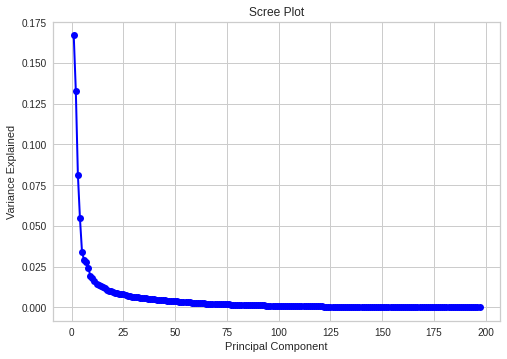

<Figure size 360x288 with 0 Axes>

In [71]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.figure(figsize=(5,4))
plt.show()

In [72]:
print( "Proporzione della varianza spiegata: " , pca.explained_variance_ratio_)  
    
out_sum  =  np.cumsum(pca.explained_variance_ratio_)  
print( "Spiegazione della varianza cumulativa prop.: " , out_sum )

Proporzione della varianza spiegata:  [1.67004196e-01 1.33040355e-01 8.14225419e-02 5.46406065e-02
 3.38692721e-02 2.89665811e-02 2.74953313e-02 2.43972874e-02
 1.93385096e-02 1.78126436e-02 1.60262753e-02 1.44898175e-02
 1.38592239e-02 1.31899470e-02 1.22500669e-02 1.15144851e-02
 1.08401257e-02 1.02404583e-02 9.74736687e-03 9.57460042e-03
 8.99897333e-03 8.56598675e-03 8.35509146e-03 8.08390263e-03
 7.83940170e-03 7.49806408e-03 7.09408249e-03 6.94680544e-03
 6.54736077e-03 6.38432404e-03 6.26392476e-03 6.03121791e-03
 5.89579315e-03 5.70409848e-03 5.62801426e-03 5.46159966e-03
 5.21938512e-03 5.19232302e-03 5.08823678e-03 4.82978605e-03
 4.73497329e-03 4.65102487e-03 4.51074018e-03 4.32524043e-03
 4.16330061e-03 4.11917471e-03 3.99949212e-03 3.89195780e-03
 3.77584668e-03 3.62884486e-03 3.52285491e-03 3.36302133e-03
 3.31637336e-03 3.26049876e-03 3.16651036e-03 3.05390268e-03
 2.90794699e-03 2.84123796e-03 2.79700718e-03 2.63173697e-03
 2.59512945e-03 2.54320215e-03 2.42343679e-03 2

In [73]:
print(pca.explained_variance_) 

[3.29178342e+01 2.62232953e+01 1.60490203e+01 1.07700912e+01
 6.67589863e+00 5.70953985e+00 5.41954500e+00 4.80889630e+00
 3.81177161e+00 3.51101147e+00 3.15890431e+00 2.85605644e+00
 2.73176151e+00 2.59984180e+00 2.41458406e+00 2.26959514e+00
 2.13667361e+00 2.01847449e+00 1.92128230e+00 1.88722868e+00
 1.77376808e+00 1.68842303e+00 1.64685392e+00 1.59340048e+00
 1.54520743e+00 1.47792712e+00 1.39829918e+00 1.36926973e+00
 1.29053605e+00 1.25840024e+00 1.23466860e+00 1.18880026e+00
 1.16210698e+00 1.12432246e+00 1.10932566e+00 1.07652404e+00
 1.02878166e+00 1.02344751e+00 1.00293130e+00 9.51988634e-01
 9.33300296e-01 9.16753405e-01 8.89102195e-01 8.52538742e-01
 8.20619137e-01 8.11921577e-01 7.88331202e-01 7.67135344e-01
 7.44248934e-01 7.15273726e-01 6.94382277e-01 6.62877827e-01
 6.53683146e-01 6.42669826e-01 6.24143977e-01 6.01948122e-01
 5.73179113e-01 5.60030240e-01 5.51312008e-01 5.18735956e-01
 5.11520326e-01 5.01285049e-01 4.77678359e-01 4.52924355e-01
 4.44709251e-01 4.326082

In [74]:
pca = PCA(n_components = 39)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [75]:
X_train_pca.shape

(1828, 39)

In [76]:
# Visualization
import plotly.express as px # for data visualization
# Create a scatter plot
fig = px.scatter(None, x=X_train_pca[:,0], y=X_train_pca[:,1], opacity=1, color=y_train['happy'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title_text="PCA Transformation")

# Update marker size
fig.update_traces(marker=dict(size=5,
                             line=dict(color='black', width=0.2)))

fig.show()

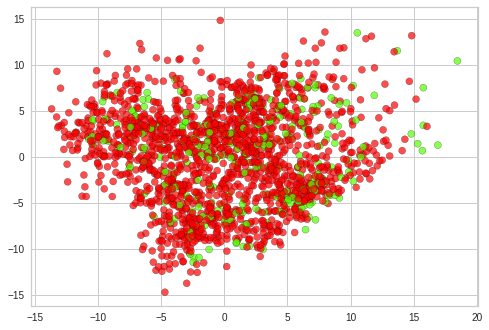

In [77]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train['happy'], 
            cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [78]:
X_test_pca = pca.transform(X_test)

In [79]:
check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_pca, y_train['happy'], dt, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 5}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
0.651 (+/-0.069) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.651 (+/-0.070) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.644 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}
0.642 (+/-0.078) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 20}
0.648 (+/-0.072) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.648 (+/-0.072) for {'criterion':

In [80]:
results

{'f1_macro': {'criterion': 'entropy',
  'max_depth': 10,
  'min_samples_leaf': 5,
  'min_samples_split': 5}}

In [81]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5, min_samples_split=5, random_state=42)
clf.fit(X_train_pca, y_train['happy'])

y_pred = clf.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7884615384615384
F1-score [0.87777778 0.21428571]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       528
           1       0.25      0.19      0.21        96

    accuracy                           0.79       624
   macro avg       0.55      0.54      0.55       624
weighted avg       0.77      0.79      0.78       624



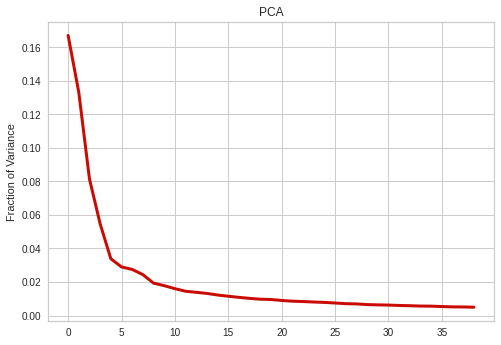

In [83]:
plt.plot(PCA(n_components=39).fit(X_train).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

RANDOM SUBSPACE PROJECTION

In [84]:
from sklearn import random_projection

In [85]:
rsp = random_projection.GaussianRandomProjection(n_components='auto', eps=0.9, random_state=42)
X_train_rsp = rsp.fit_transform(X_train)
X_train_rsp.shape

(1828, 185)

In [86]:
# Visualization
import plotly.express as px # for data visualization
# Create a scatter plot
fig = px.scatter(None, x=X_train_rsp[:,0], y=X_train_rsp[:,1], opacity=1, color=y_train['happy'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title_text="GRP Transformation")

# Update marker size
fig.update_traces(marker=dict(size=5,
                             line=dict(color='black', width=0.2)))

fig.show()

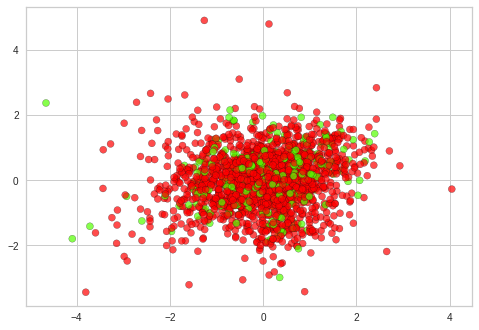

In [87]:
plt.scatter(X_train_rsp[:, 0], X_train_rsp[:, 1], c=y_train['happy'], cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [88]:
check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_rsp, y_train['happy'], dt, check_params, "f1_macro")

____________________________________________ START GRID SEARCH ____________________________________________
------- Score = f1_macro------- 

> Fold = RepeatedStratifiedKFold(n_repeats=10, n_splits=5, random_state=None)

> Best Parameter set: 

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5}

> Grid scores:

...........RESULTS FOR TRAINING.........
........................................
0.669 (+/-0.076) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 5}
0.668 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 10}
0.665 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 15}
0.662 (+/-0.075) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 20}
0.670 (+/-0.067) for {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 5}
0.670 (+/-0.067) for {'criterion': 'gi

In [89]:
results

{'f1_macro': {'criterion': 'gini',
  'max_depth': 8,
  'min_samples_leaf': 3,
  'min_samples_split': 5}}

In [93]:
X_test_rsp = rsp.transform(X_test)

clf = DecisionTreeClassifier(criterion='gini', max_depth=8, min_samples_leaf=3, min_samples_split=5, random_state=42)
clf.fit(X_train_rsp, y_train)

y_pred = clf.predict(X_test_rsp)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.7692307692307693
F1-score [0.86516854 0.2       ]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       528
           1       0.21      0.19      0.20        96

    accuracy                           0.77       624
   macro avg       0.53      0.53      0.53       624
weighted avg       0.76      0.77      0.76       624



Queste ultime 3 tecniche vengono usate solo per la visualizzazione dei dati all'interno del train set.. quindi il decision tree con questi metodi è inutile perchè viene fatto sempre sul train, poichè queste tecniche non consento la predict sul test :)

MULTI DIMENSIONAL SCALING


In [94]:
from sklearn.manifold import MDS

In [95]:
mds = MDS(n_components=2) #2 è il numero di default
X_train_mds = mds.fit_transform(X_train)
X_train_mds.shape

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning:

The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.



(1828, 2)

In [96]:
# Visualization
import plotly.express as px # for data visualization
# Create a scatter plot
fig = px.scatter(None, x=X_train_mds[:,0], y=X_train_mds[:,1], opacity=1, color=y_train['happy'])

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey', 
                 zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey', 
                 showline=True, linewidth=1, linecolor='black')

# Set figure title
fig.update_layout(title_text="MDS Transformation")

# Update marker size
fig.update_traces(marker=dict(size=5,
                             line=dict(color='black', width=0.2)))

fig.show()

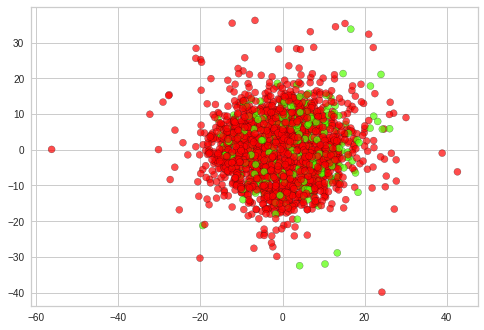

In [97]:
plt.scatter(X_train_mds[:, 0], X_train_mds[:, 1], c=y_train['happy'], cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [112]:
"""check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_mds, y_res, dt, check_params, "f1_macro")"""

'check_params ={"criterion":["gini", "entropy"],\n         "max_depth":[4, 6, 8, 10],\n         "min_samples_split": [5, 10, 15, 20],\n         "min_samples_leaf": [3, 5, 7, 9, 11]}\ndt=DecisionTreeClassifier()\nresults = customGridSearch(X_train_mds, y_res, dt, check_params, "f1_macro")'

In [111]:
#results

In [110]:
"""clf = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=3,min_samples_split=10, random_state=42)
clf.fit(X_train_mds, y_res)

y_pred = clf.predict(X_train_mds)

print('Accuracy %s' % accuracy_score(y_res, y_pred))
print('F1-score %s' % f1_score(y_res, y_pred, average=None))
print(classification_report(y_res, y_pred))"""

"clf = DecisionTreeClassifier(criterion='gini',max_depth=10,min_samples_leaf=3,min_samples_split=10, random_state=42)\nclf.fit(X_train_mds, y_res)\n\ny_pred = clf.predict(X_train_mds)\n\nprint('Accuracy %s' % accuracy_score(y_res, y_pred))\nprint('F1-score %s' % f1_score(y_res, y_pred, average=None))\nprint(classification_report(y_res, y_pred))"

IsoMap

In [98]:
from sklearn.manifold import Isomap

In [99]:
iso = Isomap(n_components=2) #2 è il default
X_train_iso = iso.fit_transform(X_train)
X_train_iso.shape

(1828, 2)

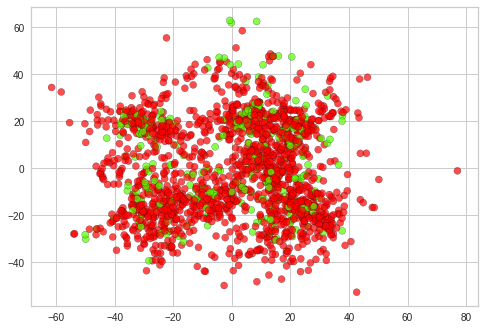

In [100]:
plt.scatter(X_train_iso[:, 0], X_train_iso[:, 1], c=y_train['happy'], cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [109]:
"""check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_iso, y_res, dt, check_params, "f1_macro")"""

'check_params ={"criterion":["gini", "entropy"],\n         "max_depth":[4, 6, 8, 10],\n         "min_samples_split": [5, 10, 15, 20],\n         "min_samples_leaf": [3, 5, 7, 9, 11]}\ndt=DecisionTreeClassifier()\nresults = customGridSearch(X_train_iso, y_res, dt, check_params, "f1_macro")'

In [108]:
#results

In [107]:
"""clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3, min_samples_split=5, random_state=42)
clf.fit(X_train_iso, y_res)

y_pred = clf.predict(X_train_iso)

print('Accuracy %s' % accuracy_score(y_res, y_pred))
print('F1-score %s' % f1_score(y_res, y_pred, average=None))
print(classification_report(y_res, y_pred))"""

"clf = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=3, min_samples_split=5, random_state=42)\nclf.fit(X_train_iso, y_res)\n\ny_pred = clf.predict(X_train_iso)\n\nprint('Accuracy %s' % accuracy_score(y_res, y_pred))\nprint('F1-score %s' % f1_score(y_res, y_pred, average=None))\nprint(classification_report(y_res, y_pred))"

t-SNE

In [101]:
from sklearn.manifold import TSNE

In [102]:
tsne = TSNE(n_components=2) #2 è il default
X_train_tsne = tsne.fit_transform(X_train)
X_train_tsne.shape

(1828, 2)

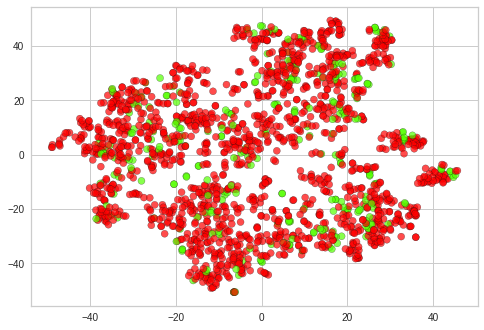

In [103]:
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train['happy'], cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [104]:
"""check_params ={"criterion":["gini", "entropy"],
         "max_depth":[4, 6, 8, 10],
         "min_samples_split": [5, 10, 15, 20],
         "min_samples_leaf": [3, 5, 7, 9, 11]}
dt=DecisionTreeClassifier()
results = customGridSearch(X_train_tsne, y_res, dt, check_params, "f1_macro")"""

'check_params ={"criterion":["gini", "entropy"],\n         "max_depth":[4, 6, 8, 10],\n         "min_samples_split": [5, 10, 15, 20],\n         "min_samples_leaf": [3, 5, 7, 9, 11]}\ndt=DecisionTreeClassifier()\nresults = customGridSearch(X_train_tsne, y_res, dt, check_params, "f1_macro")'

In [106]:
#results

In [105]:
"""clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_leaf=3,min_samples_split=5, random_state=42)
clf.fit(X_train_tsne, y_res)

y_pred = clf.predict(X_train_tsne)

print('Accuracy %s' % accuracy_score(y_res, y_pred))
print('F1-score %s' % f1_score(y_res, y_pred, average=None))
print(classification_report(y_res, y_pred))"""

"clf = DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_leaf=3,min_samples_split=5, random_state=42)\nclf.fit(X_train_tsne, y_res)\n\ny_pred = clf.predict(X_train_tsne)\n\nprint('Accuracy %s' % accuracy_score(y_res, y_pred))\nprint('F1-score %s' % f1_score(y_res, y_pred, average=None))\nprint(classification_report(y_res, y_pred))"